# **xView NRMM Object Detection--Initialization**

This notebook is for initialize the YOLOv8 for NRMM detection on xView dataset, following the tutorial from https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/



##1.YOLOv8 Installation

Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Pip install method

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.2/166.8 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

##2.Testing with pre-trained COCO dataset YOLOv8

Running detecting rask on COCO dataset using YOLOv8n.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
100% 6.23M/6.23M [00:00<00:00, 263MB/s]

2023-06-26 15:55:10.213656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:55:12.288977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
100% 104k/104k [00:00<00:00, 104MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 78.6ms
Speed: 0.7ms pre-process, 78.6ms inference, 319.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


/content


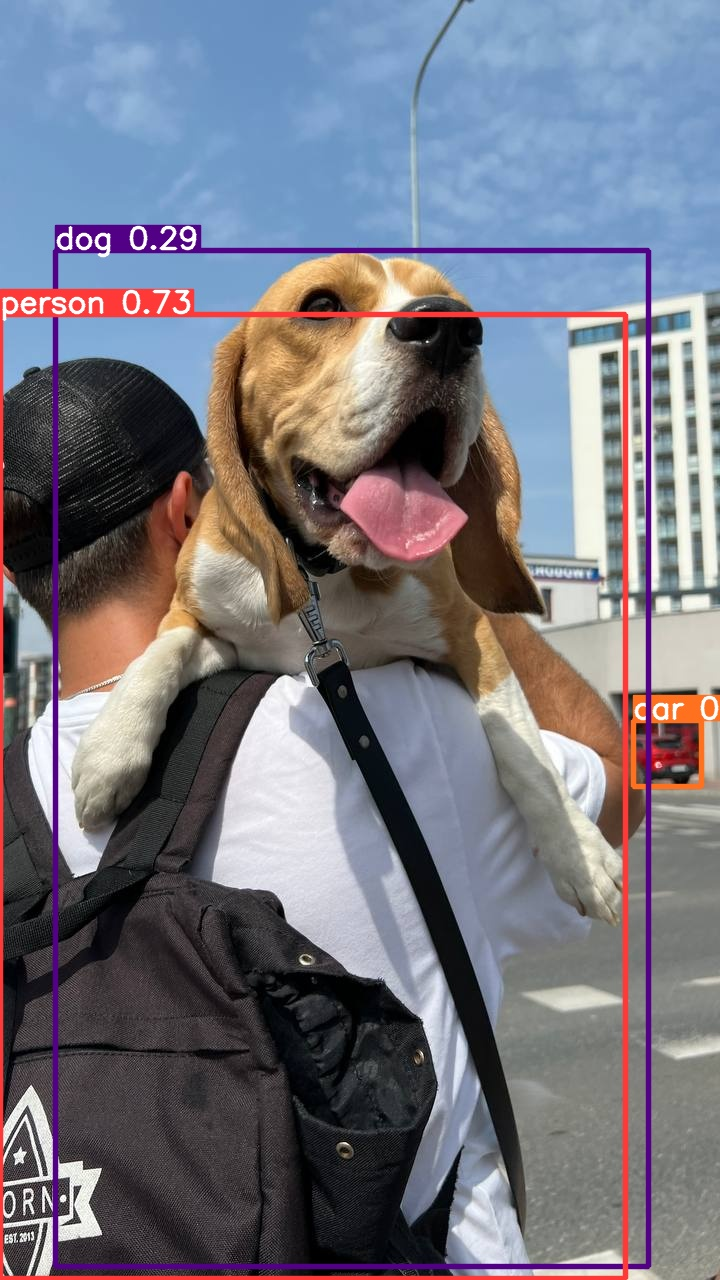

In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='drive/MyDrive/raw_data/train_images/t_train1.png' save=True

/content
100% 6.23M/6.23M [00:00<00:00, 209MB/s]

2023-07-05 20:24:29.925984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 20:24:30.756644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/drive/MyDrive/raw_data/train_images/t_train1.png: 608x640 1 boat, 104.4ms
Speed: 0.8ms pre-process, 104.4ms inference, 340.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


Using the non-tained model to detect NRMM. Nothing is detected as expected.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='drive/MyDrive/raw_data/train_images/t_train2.png' save=True

/content
2023-06-26 16:06:00.809501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 16:06:01.982614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/drive/MyDrive/raw_data/train_images/t_train2.png: 608x640 59.2ms
Speed: 0.8ms pre-process, 59.2ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict2/t_train2.png', height=600)

Output hidden; open in https://colab.research.google.com to view.

##3. Prepare our xView dataset



Convert the training tif images to png format.

Convert the geojson labeling file into YOLO pytorch txt. Implementing the method from https://github.com/ultralytics/yolov5/blob/master/data/xView.yaml and https://github.com/ultralytics/yolov5/blob/master/utils/general.py


In [ ]:
import json
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm



def xyxy2xywhn(box, w, h, clip=False):
    # Convert nx4 boxes from [xmin, ymin, xmax, ymax] to [x_center, y_center, width, height] where all 4 are normalized
    box = box.copy()  # ensure copy
    box[:, :2] = (box[:, :2] + box[:, 2:]) / 2  # x_center, y_center
    box[:, 2:] = box[:, 2:] - box[:, :2]  # width, height
    box[:, :2] /= [w, h]  # x_center, y_center normalization
    box[:, 2:] /= [w, h]  # width, height normalization
    if clip:
        box = box.clip(0, 1)  # limit all coordinates to range 0-1
    return box


def convert_labels(path_to_geojson, path_to_images, path_to_labels):
    # Convert xView geoJSON labels to YOLO format
    with open(path_to_geojson) as f:
        print(f'Loading {path_to_geojson}...')
        data = json.load(f)

    # Make dirs
    labels = Path(path_to_labels)
    labels.mkdir(parents=True, exist_ok=True)

    # xView classes 0-59 to 0-59
    #xview_class2index = list(range(60))

    # xView classes 11-94 to 0-59
    xview_class2index = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 2, -1, 3, -1, 4, 5, 6, 7, 8, -1, 9, 10, 11,
                           12, 13, 14, 15, -1, -1, 16, 17, 18, 19, 20, 21, 22, -1, 23, 24, 25, -1, 26, 27, -1, 28, -1,
                           29, 30, 31, 32, 33, 34, 35, 36, 37, -1, 38, 39, 40, 41, 42, 43, 44, 45, -1, -1, -1, -1, 46,
                           47, 48, 49, -1, 50, 51, -1, 52, -1, -1, -1, 53, 54, -1, 55, -1, -1, 56, -1, 57, -1, 58, 59]

    shapes = {}
    for feature in tqdm(data['features'], desc=f'Converting {path_to_geojson}'):
        p = feature['properties']
        if p['bounds_imcoords']:
            id = p['image_id']
            file = Path(path_to_images) / id
            if file.exists():
                try:
                    if id not in shapes:
                        shapes[id] = Image.open(file).size

                    # Read the box values and clip them to the image dimensions
                    box = np.array([int(num) for num in p['bounds_imcoords'].split(",")])
                    box = np.clip(box, 0, [shapes[id][0], shapes[id][1], shapes[id][0], shapes[id][1]])
                    assert box.shape[0] == 4, f'incorrect box shape {box.shape[0]}'

                    cls = p['type_id']
                    cls = xview_class2index[int(cls)]  # xView class to 0-60
                    assert 59 >= cls >= 0, f'incorrect class index {cls}'

                    # Write YOLO label
                    box = xyxy2xywhn(box[None].astype(np.float), w=shapes[id][0], h=shapes[id][1], clip=True)
                    with open((labels / id).with_suffix('.txt'), 'a') as f:
                        f.write(f"{cls} {' '.join(f'{x:.6f}' for x in box[0])}\n")  # write label.txt
                except Exception as e:
                    print(f'WARNING: skipping one label for {file}: {e}')



# Call the function
convert_labels('drive/MyDrive/raw_data/xView_train.geojson', 'drive/MyDrive/raw_data/train_images', 'drive/MyDrive/raw_data/train_labels')


Loading drive/MyDrive/raw_data/xView_train.geojson...


Converting drive/MyDrive/raw_data/xView_train.geojson:   0%|          | 0/601937 [00:00<?, ?it/s]<ipython-input-37-187d871ec338>:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  box = xyxy2xywhn(box[None].astype(np.float), w=shapes[id][0], h=shapes[id][1], clip=True)
Converting drive/MyDrive/raw_data/xView_train.geojson:   4%|▍         | 23231/601937 [01:37<27:53, 345.87it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:   4%|▍         | 23662/601937 [01:38<27:52, 345.77it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:   4%|▍         | 26894/601937 [01:51<33:41, 284.50it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:   5%|▌         | 30196/601937 [02:10<38:10, 249.59it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:   7%|▋         | 41543/601937 [03:12<26:54, 347.08it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:   7%|▋         | 43604/601937 [03:24<1:08:30, 135.83it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  10%|▉         | 57548/601937 [04:36<34:15, 264.88it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  10%|▉         | 58913/601937 [04:43<24:29, 369.47it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  11%|█         | 64212/601937 [05:18<1:48:48, 82.37it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  11%|█         | 64380/601937 [05:18<41:49, 214.25it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  13%|█▎        | 75884/601937 [06:29<24:16, 361.08it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  13%|█▎        | 76140/601937 [06:30<39:43, 220.62it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  19%|█▊        | 111424/601937 [09:04<24:15, 337.12it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  20%|██        | 121210/601937 [09:47<26:03, 307.54it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  20%|██        | 121652/601937 [09:48<25:55, 308.73it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  20%|██        | 122688/601937 [09:51<22:39, 352.51it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  20%|██        | 123095/601937 [09:52<22:17, 358.08it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  21%|██        | 123914/601937 [09:59<2:01:24, 65.62it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  21%|██        | 125209/601937 [10:03<22:11, 357.95it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  21%|██▏       | 128759/601937 [10:15<21:49, 361.30it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  22%|██▏       | 129657/601937 [10:18<21:46, 361.47it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  22%|██▏       | 130142/601937 [10:19<23:11, 339.08it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  22%|██▏       | 130575/601937 [10:20<26:27, 296.87it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  25%|██▌       | 152966/601937 [12:55<00:38, 11575.47it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  82%|████████▏ | 495672/601937 [15:28<04:36, 384.50it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  83%|████████▎ | 499561/601937 [15:43<05:33, 307.21it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  98%|█████████▊| 588060/601937 [22:41<00:39, 353.16it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  98%|█████████▊| 588849/601937 [22:43<00:36, 358.58it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  98%|█████████▊| 591051/601937 [22:51<00:36, 296.68it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson:  98%|█████████▊| 591327/601937 [22:52<00:32, 326.91it/s]

Converting drive/MyDrive/raw_data/xView_train.geojson: 100%|██████████| 601937/601937 [23:48<00:00, 421.43it/s]






*   Download the txt label file, and then upload all the images (in jpg) and label file (in txt) to roboflow.
*   And our data is ready to be processed:
*   Resize: Stretch to 640x640
*   Tile: 8 rows x 8 columns
*   Modify Classes: 14 remapped, 47 dropped
    *   In this notebook, all NRMM related classes are rewritten as "NRMM" so it is a one class detection task.
*   Flip: Horizontal

*   Download our processed xView dataset from roboflow




In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AXtvn8E5cqIPHd94QNpU")
project = rf.workspace("university-college-london-pmvix").project("nrmm")
dataset = project.version(1).download("yolov8")

#dataset = project.version(1).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=37586bbb7596bdada7814da4b32c6fa4134a9526897e52d75e117c11a4737acd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to -NRMM-1 in yolov8:: 100%|██████████| 93708/93708 [00:10<00:00, 9097.65it/s] 




*   in data.yaml (content/-NRMM-3/data.yaml)file, the path of data need to be exact paths:
  *   test: /content/-NRMM-3/test/images
  *   train: /content/-NRMM-3/train/images
  *   val: /content/-NRMM-3/valid/images








##4. Train YOLOv8 on our xVeiw dataset


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/-NRMM-1/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simpl

/content


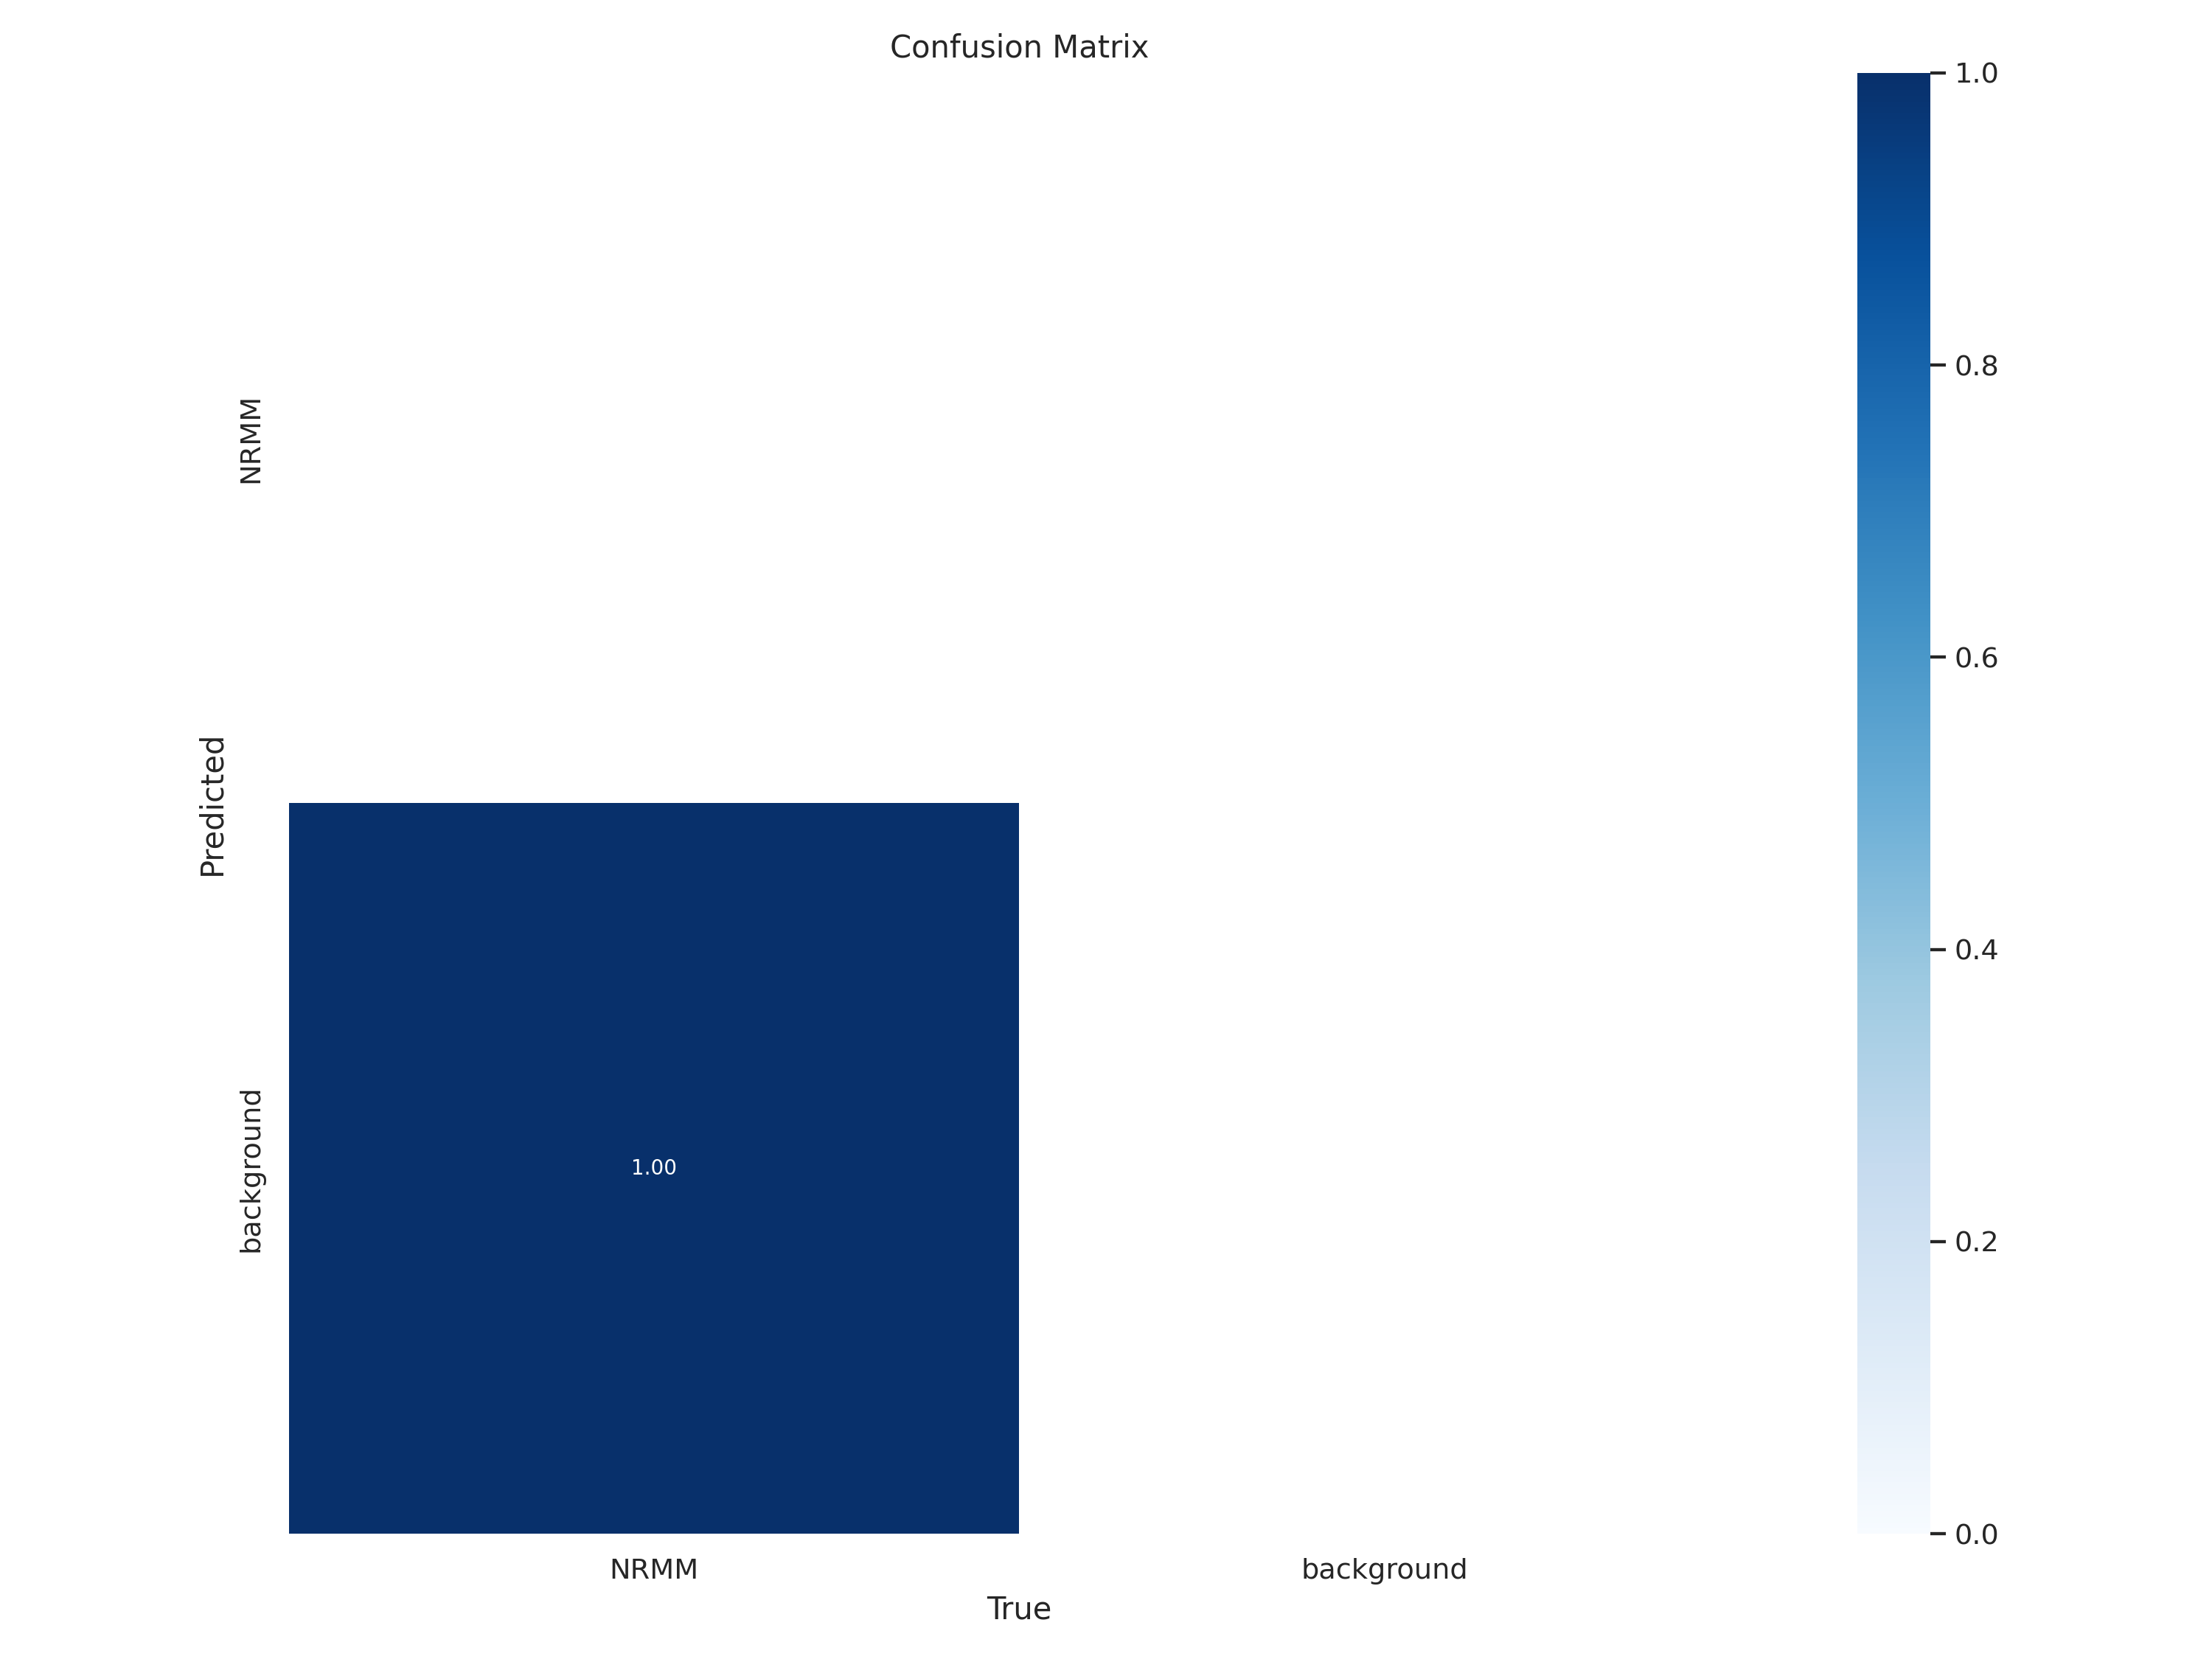

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

/content


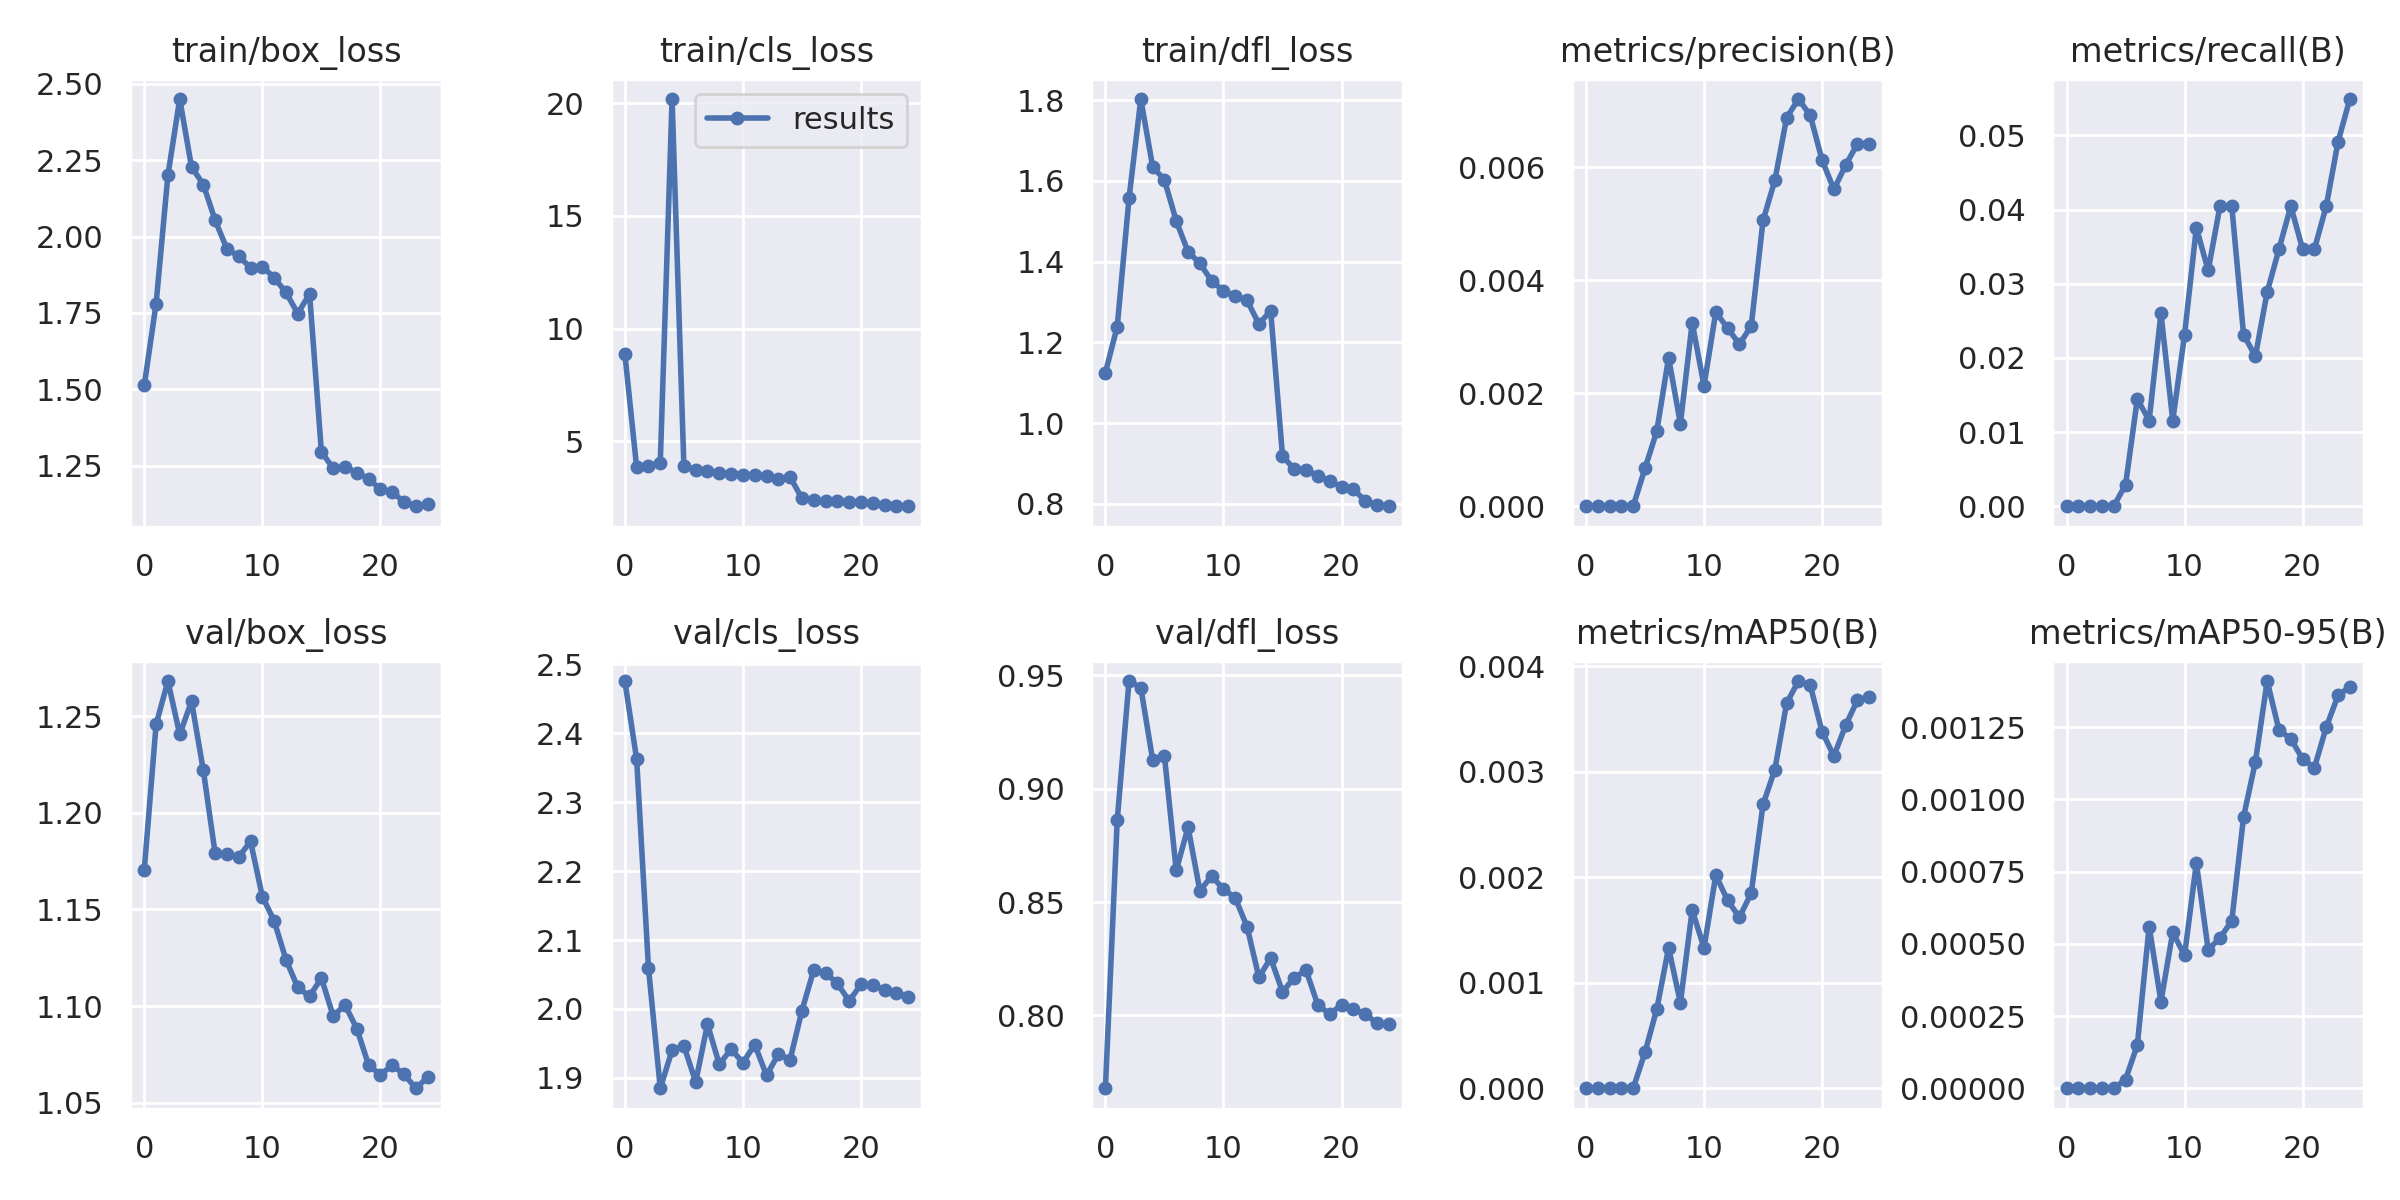

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/content


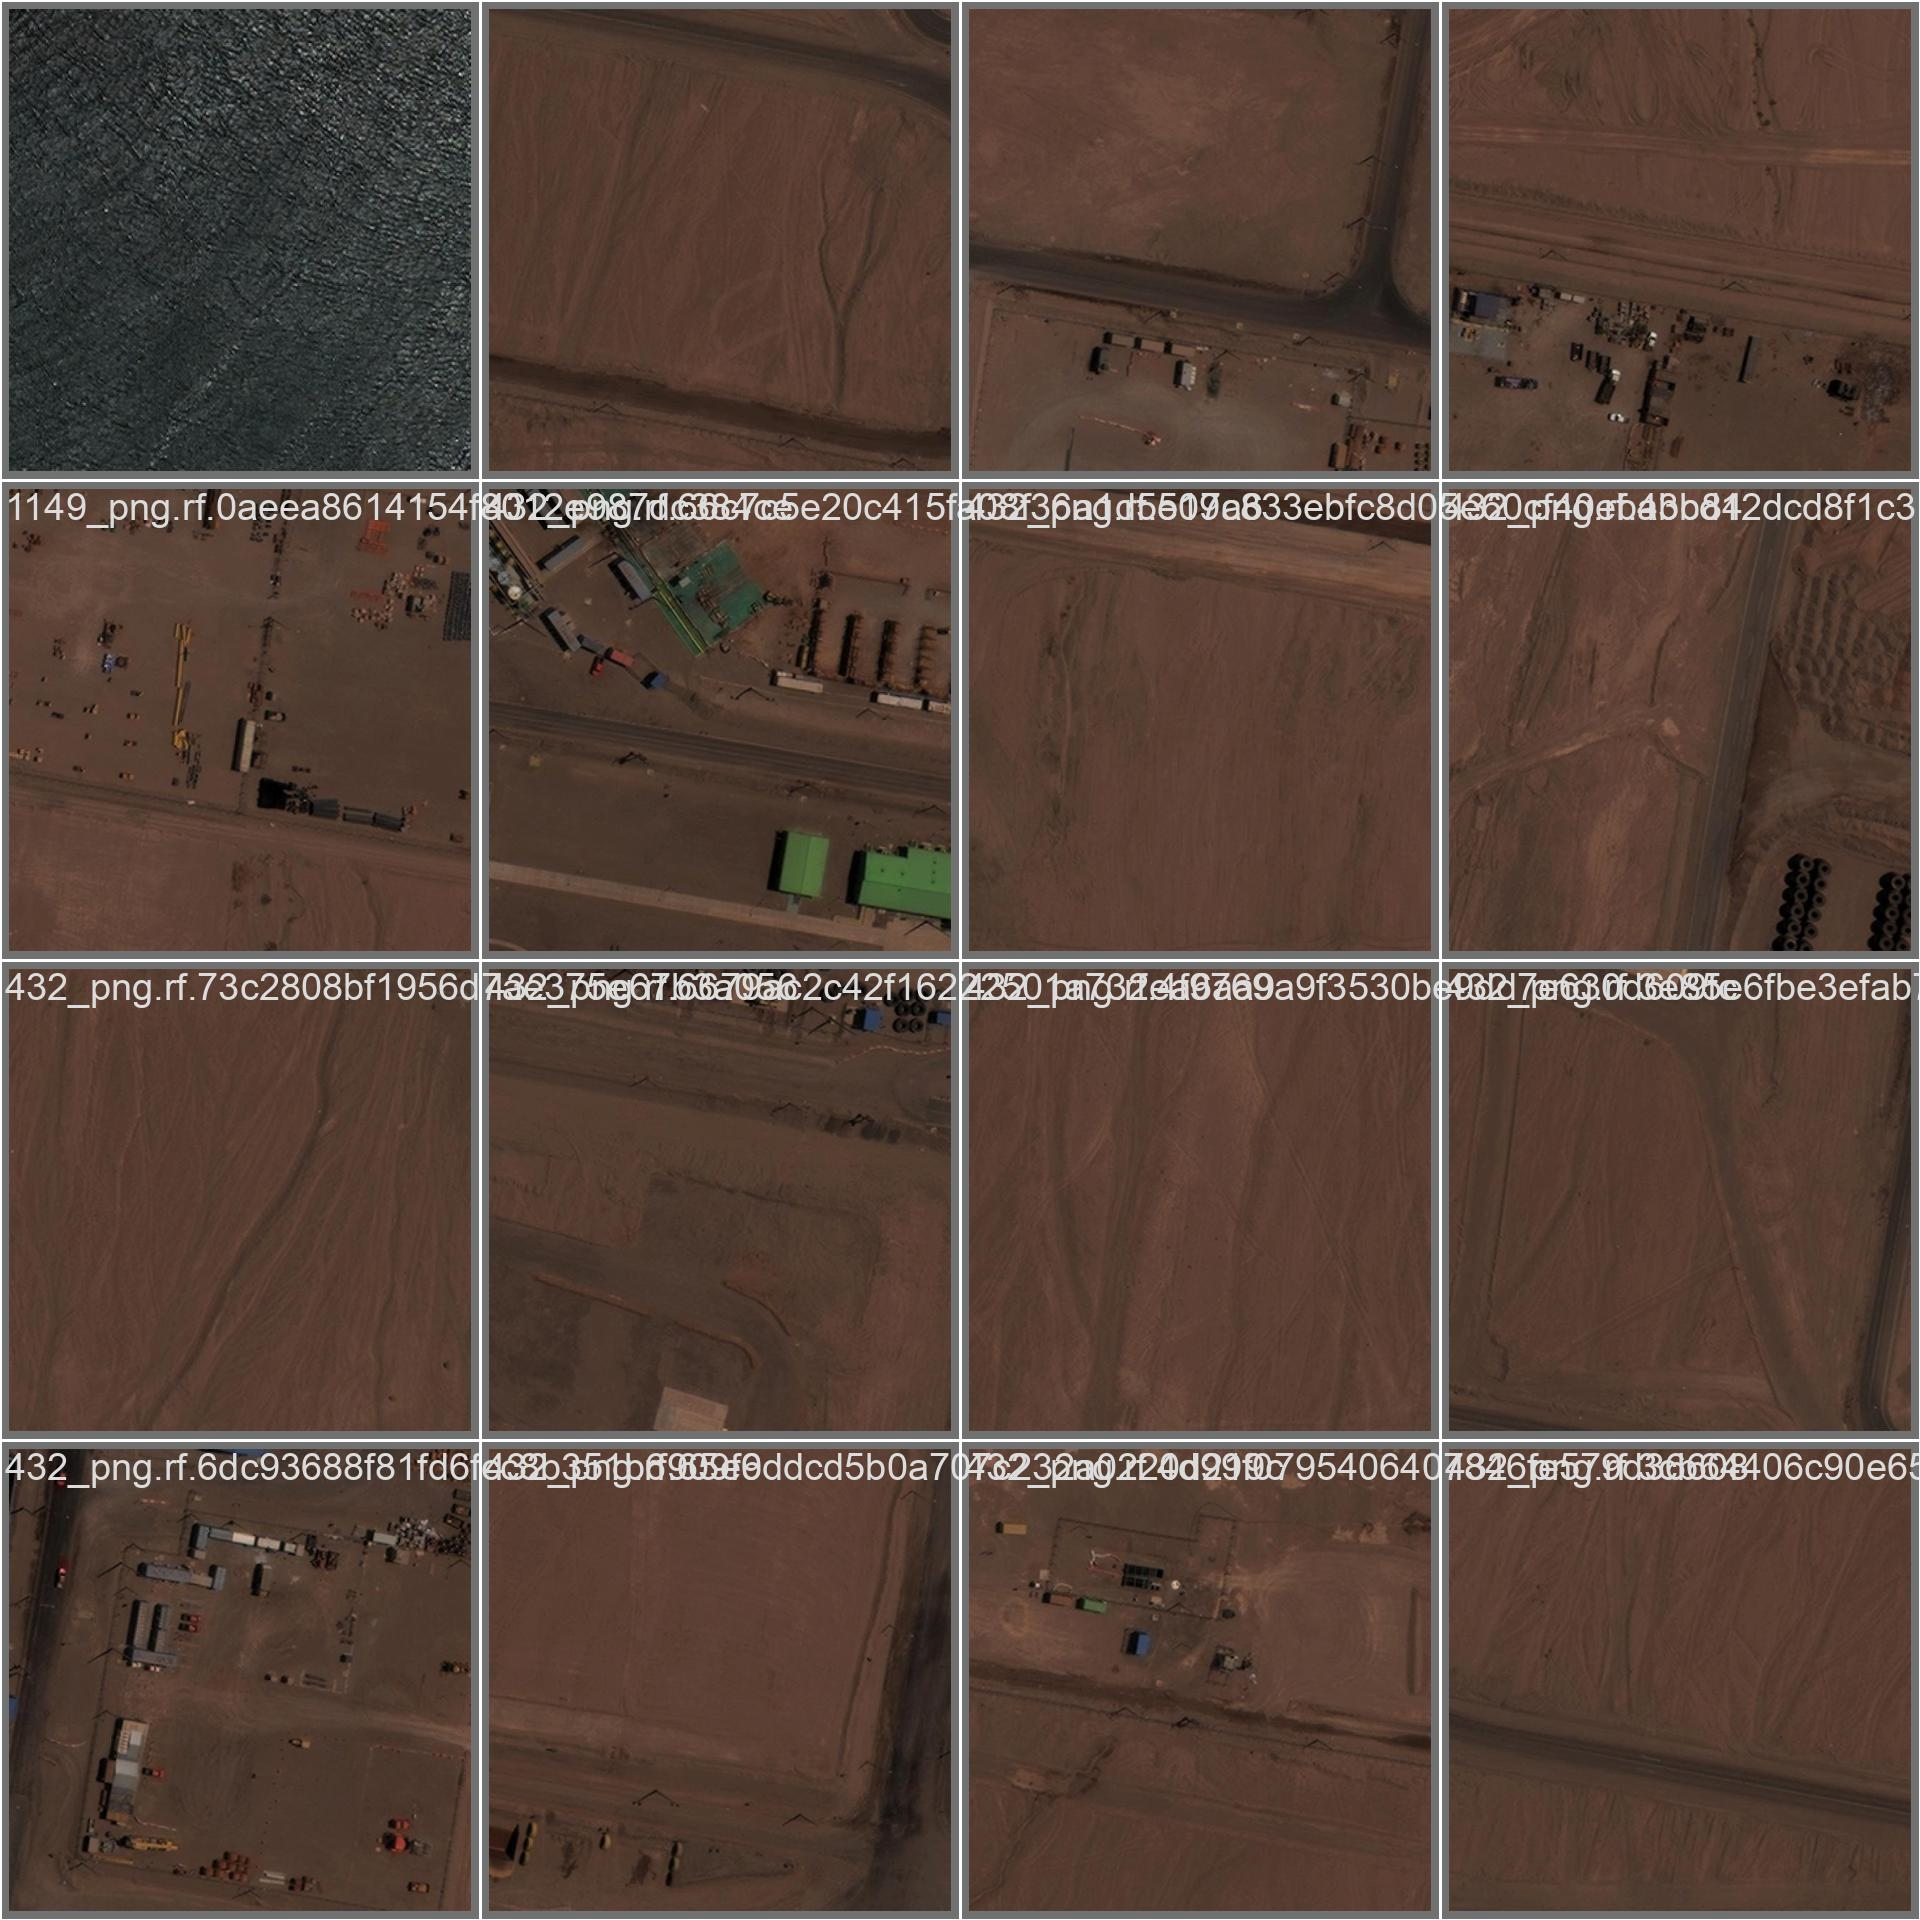

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

/content
2023-07-12 15:08:45.191090: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 15:08:45.244588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 15:08:46.136137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/-NRMM-1/valid/labels.cache... 5504 im

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

/content
2023-07-12 15:09:41.501700: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 15:09:41.554553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 15:09:42.424997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
image 1/2816 /content/-NRMM-1/test/images/1063_png.rf.082c2d

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[60:100]:
      display(Image(filename=image_path, width=600))
      print("\n")

The results are bad and it should realtes to all the NRMM classes are combined into one.
Scince multiple shapes and colors might confuse the model to learn.